In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.7.2


In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [4]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


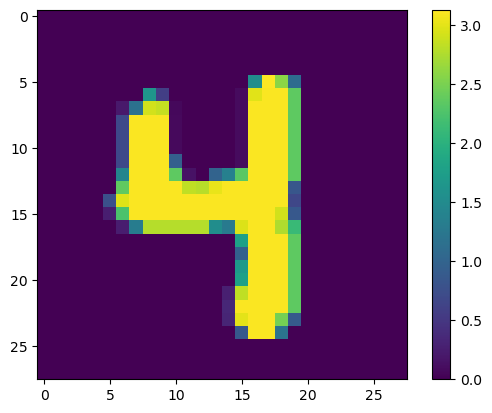

In [5]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [6]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

4


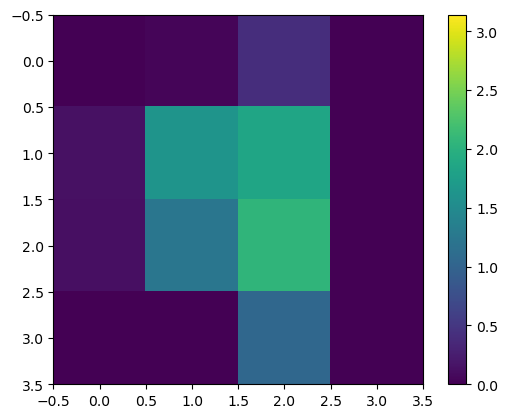

In [7]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [61]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

c:\Users\Himank\anaconda3\envs\qiskit\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 1, 32)`, `kernel shape=(3, 3, 32, 64)`, `dilation_rate=[1 1]`.

In [124]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [147]:
classifier = SamplerQNN(
    circuit = circuit,
    output_shape = 2,
    interpret = lambda x: x%2,
    )

sampler_classifier = NeuralNetworkClassifier(neural_network=classifier, optimizer=COBYLA(maxiter=20), warm_start = True, callback=callback_graph)

In [151]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0, 1, or 2 to properly process in samplerqnn.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    else: y_temp.append(2)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    else: y1_temp.append(2)
y1=y_temp

x = x[0:1000]
y = y[0:1000]
x1 = x1[0:1000]
y1 = y1[0:1000]

In [152]:
counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

def balance_lists(x, y, max_count=452):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1

    return x_balanced, y_balanced

x, y = balance_lists(x, y)

counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

print(x)
print(y)

477 523
452 452
[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.4734389  0.20214808 ... 0.5202045  0.43572468 0.        ]
 [0.         1.0911974  0.37714198 ... 0.7135526  1.108546   0.08975979]
 [0.01684568 0.7273811  0.55842155 ... 0.897095   0.7303983  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1
 1 1 1 0 0 1 0 

In [153]:
def fun(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

# Calling this function
x,y = fun(x,y)

# x=x[0:6]
# y=y[0:6]
# x1=x1[0:10]
# y1=y1[0:10]

print(x)
print(y)

counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

[[0.         0.20767951 0.         ... 0.37487912 0.11565687 0.        ]
 [0.         0.         0.29266217 ... 0.         0.6019186  0.        ]
 [0.12269685 0.9214835  0.7681125  ... 0.6071986  0.996409   0.19183955]
 ...
 [0.         0.3570277  0.5199531  ... 1.3732997  0.4181247  0.        ]
 [0.         0.         0.12722257 ... 0.         0.7301468  0.        ]
 [0.03972562 0.8033125  0.4548332  ... 1.1299174  1.0635403  0.00351999]]
[1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1
 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1
 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1
 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0
 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1
 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0
 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 

weights [1.34676341e-01 7.73190951e-02 3.22208784e-01 2.93453363e-01
 5.71314869e-01 2.10255471e-01 6.63007068e-01 2.47786233e-01
 4.26884238e-01 5.31164579e-01 4.31700023e-01 4.23170831e-01
 9.34493167e-01 5.71945925e-01 5.45784984e-01 6.75865515e-01
 7.41115715e-01 5.24608414e-01 1.06440131e-01 6.32675416e-01
 9.04719036e-01 8.47277637e-02 1.30933348e-02 9.44622051e-01
 2.78003620e-01 2.18310070e-01 7.37452811e-01 6.84077731e-03
 4.44028252e-01 2.18448361e-01 8.01867413e-01 2.11665009e-01
 3.25588287e-01 7.29806934e-01 1.31184697e-01 9.20823382e-01
 3.43198270e-02 1.09594707e-01 9.62711101e-01 1.18148837e-01
 9.81271633e-01 6.32392062e-01 7.08831956e-01 7.37757321e-01
 5.63711991e-01 5.00694394e-01 4.05111651e-01 9.10520438e-01
 1.42017515e-02 1.28544313e-01 1.89145892e-01 7.32461091e-01
 1.82600748e-02 8.15808188e-01 9.06415392e-01 1.13141454e-01
 9.58997582e-01 6.79218670e-01 4.17991771e-01 9.54847419e-01
 6.64587322e-01 6.15744280e-01 2.27254144e-01 6.18832447e-01
 1.20444518e-01 

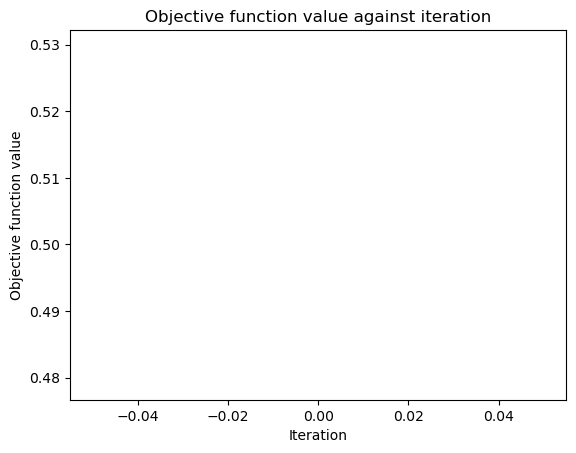

In [ ]:
sampler_classifier.fit(x,y)

In [ ]:
print(f"Accuracy from the train data: {np.round(100 * sampler_classifier.score(x, y), 2)}%")

Accuracy from the train data: 100.0%


In [ ]:
y_predict = sampler_classifier.predict(x1)
print(f"Accuracy from the test data: {np.round(100 * sampler_classifier.score(x1, y1), 2)}%")

Accuracy from the test data: 50.0%


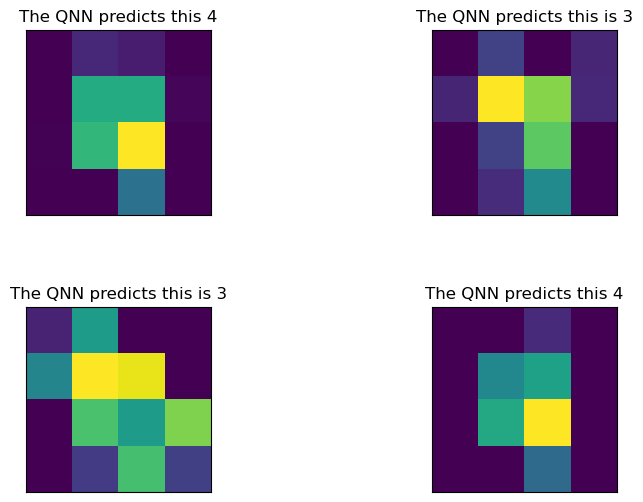

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QNN predicts this 4")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QNN predicts this 5")   
    if y_predict[i] == 3:
        ax[i // 2, i % 2].set_title("The QNN predicts this 6") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
y_predict

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
y1

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
weight = sampler_classifier.weights 
weight

array([0.21345011, 1.72601699, 0.19968601, 0.71100134, 1.0131314 ,
       1.63883047, 0.31437906, 0.1343702 , 0.27830223, 0.25446905,
       0.51971782, 1.30251302, 1.05452029, 0.1726625 , 0.66103942,
       1.05796606, 1.91476529, 0.38996832, 1.92484175, 0.42633541,
       0.69985387, 0.7894824 , 0.1778609 , 0.74319914, 0.25918788,
       0.99317172, 0.00935137, 0.68592271, 0.68522907, 0.15892082,
       0.07525929, 0.96947647, 0.14744429, 0.75961825, 0.51541941,
       0.57660246, 0.39450938, 0.36215328, 0.34707426, 0.40861333,
       0.83137168, 0.04929068, 0.50394527, 0.67331121, 0.82850505,
       0.85898287, 0.02965496, 0.45469644, 0.85271748, 0.5326538 ,
       0.62658183, 0.63584332, 0.53735224, 0.734075  , 0.77616992,
       0.6494329 , 0.35916017, 0.76692066, 0.76575788, 0.56288243,
       0.11309712, 0.67226704, 0.24773613, 0.09600041, 0.1781242 ,
       0.88590023, 0.12875365, 0.32385934, 0.93444519, 0.88137208,
       0.12512265, 0.23488427, 0.15892972, 0.39310932, 0.12465

In [ ]:
sampler_classifier.save("model1")